# CAICT 風機結冰預測 - Deep Learning

2017/07/12  
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

# **1. Load Data and Modules**

**Load Python modules:**

In [43]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import pandas as pd
import os
import sys
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import shutil
import csv
import sklearn as sk
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from IPython.core.interactiveshell import InteractiveShell
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
import sklearn
from sklearn import preprocessing

import keras.backend as K
import numpy as np
import random
import sys
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence

from scipy.stats import spearmanr
from scipy.stats import pearsonr
import sklearn
import xgboost as xgb

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "none"
import warnings
warnings.filterwarnings('ignore')

In [2]:
def updateProgress(msg):
    sys.stdout.write('\r')
    sys.stdout.write(msg)
    sys.stdout.flush()
    
def myscore(true_y, pred_y):
    n,p =sk.metrics.confusion_matrix(true_y, pred_y)
    tn = n[0]
    fp = n[1]
    fn = p[0]
    tp = p[1]
    #print('tn:',tn,'fp:',fp,'fn:',fn,'fp:',fp)
    score = 1- 0.5*(fp/(tn+fp))- 0.5*(fn/(fn+tp)) 
    #print('score',score)
    return score, {'tn':tn,'fp':fp,'fn':fn,'tp':tp}


In [3]:
def StandardScaler(data):
    standard_scaler = preprocessing.StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled

def MinMaxScaler(data):
    standard_scaler = preprocessing.MinMaxScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled



##------------------------

def load_resample_data(mid, policy=1,  ycol='power', fillna=0):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    print('load file:',filename)
    data_resample = pd.read_csv(filename)
    #data_resample['label']=data_resample['label'].fillna(fillna)
    data_resample.loc[data_resample.label == 2, 'label'] = 0
    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    #data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    non_data_cols = ['label','time','group','timestamp','event']
    data_scaled = MinMaxScaler(data_X)
    for col in non_data_cols:
        data_scaled[col] = data_resample[col]
    return data_resample,data_scaled

##------------------------

def load_test2_data():
    test_data = pd.read_csv('data/ice1/test/08/08_data.csv')
    test_timeidx = test_data['time']
    tmp = test_data.drop(['time','group','generator_speed'], axis=1)
    test_X = tmp.values
    return test_X, test_timeidx

    

In [4]:
def rnn_dataset(data, n_steps):
    dataset_new = []
    for idx, _ in enumerate(data):
        start_idx = idx-n_steps
        end_idx = idx+1
        if start_idx<0:
            continue
        n=np.concatenate(data[start_idx:end_idx], axis=0)
        dataset_new.append(n)
    dataset_new = np.asarray(dataset_new)
    return dataset_new
    

**Load input data.** 

TODO: nomalize,  



In [5]:
xcols=['wind_speed', 'wind_direction', 
       'wind_direction_mean', 'yaw_position', 'yaw_speed', 'pitch1_angle',
       'pitch2_angle', 'pitch3_angle', 'pitch1_speed', 'pitch2_speed',
       'pitch3_speed', 'pitch1_moto_tmp', 'pitch2_moto_tmp', 'pitch3_moto_tmp',
       'acc_x', 'acc_y', 'environment_tmp', 'int_tmp', 'pitch1_ng5_tmp',
       'pitch2_ng5_tmp', 'pitch3_ng5_tmp', 'pitch1_ng5_DC', 'pitch2_ng5_DC',
       'pitch3_ng5_DC']


In [6]:
data_scaled_M15_raw, data_scaled_M15 = load_resample_data(mid=15,policy=0)

data_M15_train = data_scaled_M15[data_scaled_M15['label']==0]
ycol='power'

data_M15_train_X = data_M15_train[xcols]
data_M15_train_y = data_M15_train[ycol]
data_M15_train_Y = np.eye(data_M15_train_y.unique().size)[data_M15_train_y.values.astype(int)]


data_M15_test_X = data_scaled_M15[xcols]
data_M15_test_y = data_scaled_M15[ycol]
data_M15_test_Y = np.eye(data_M15_test_y.unique().size)[data_M15_test_y.values.astype(int)]


_, data_scaled_M21 = load_resample_data(mid=21,policy=0)
data_M21_test_X = data_scaled_M21[xcols]
data_M21_test_y = data_scaled_M21[ycol]
data_M21_test_Y = np.eye(data_M21_test_y.unique().size)[data_M21_test_y.values.astype(int)]




load file: data/resample_data_p0_15.csv
load file: data/resample_data_p0_21.csv


** 為了RNN需求, 更改X format **

In [7]:
n_steps = 50
n_steps_=n_steps-1
data_M15_train_X_new = rnn_dataset(data_M15_train_X.values,n_steps_)
#data_M15_valid_X_new = rnn_dataset(data_M15_valid_X.values,n_steps_)
data_M21_test_X_new = rnn_dataset(data_M21_test_X.values,n_steps_)
data_M15_test_X_new = rnn_dataset(data_M15_test_X.values,n_steps_)
#test_X = rnn_dataset(test_X,n_steps_)

data_M15_train_X_new = data_M15_train_X_new.reshape([-1, 50, len(xcols)])
#data_M15_valid_X_new = data_M15_valid_X_new.reshape([-1, 50, len(xcols)])
data_M21_test_X_new = data_M21_test_X_new.reshape([-1, 50, len(xcols)])
data_M15_test_X_new = data_M15_test_X_new.reshape([-1, 50, len(xcols)])
#test_X = test_X.reshape([-1, 50, len(xcols)])

In [8]:
data_M15_train_Y_new=data_M15_train_Y[n_steps_:]
data_M15_train_y_new=data_M15_train_y[n_steps_:]
#data_M15_valid_Y_new=data_M15_valid_Y[n_steps_:]
#data_M15_valid_y_new=data_M15_valid_y[n_steps_:]
data_M21_test_Y_new=data_M21_test_Y[n_steps_:]
data_M21_test_y_new=data_M21_test_y[n_steps_:]
data_M15_test_Y_new=data_M15_test_Y[n_steps_:]
data_M15_test_y_new=data_M15_test_y[n_steps_:]
#test_timeidx_new=test_timeidx[n_steps_:]

** 3. RNN ** 

In [9]:
model = Sequential()
model.add(LSTM(50, input_shape=(50, len(xcols)), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mse", optimizer=optimizer)



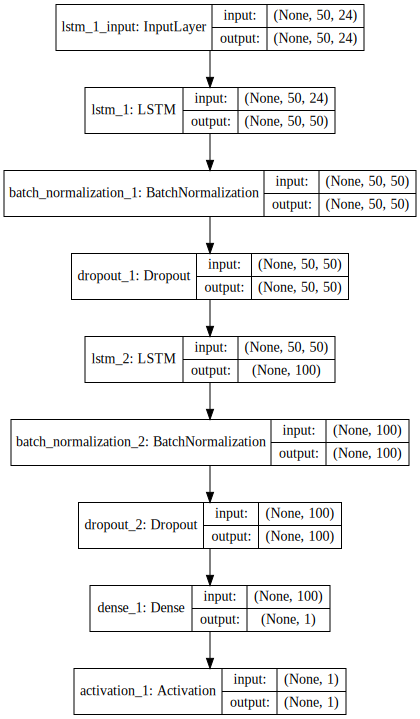

In [10]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
model.fit(data_M15_train_X_new, data_M15_train_y_new, batch_size=256, epochs=10)


Epoch 1/10
369945/369945 [==============================] - 112s - loss: 0.0666   
Epoch 2/10
369945/369945 [==============================] - 110s - loss: 0.0032   
Epoch 3/10
369945/369945 [==============================] - 110s - loss: 0.0029   
Epoch 4/10
369945/369945 [==============================] - 109s - loss: 0.0025   
Epoch 5/10
369945/369945 [==============================] - 108s - loss: 0.0022   
Epoch 6/10
369945/369945 [==============================] - 108s - loss: 0.0021   
Epoch 7/10
369945/369945 [==============================] - 108s - loss: 0.0019   
Epoch 8/10
369945/369945 [==============================] - 108s - loss: 0.0018   
Epoch 9/10
369945/369945 [==============================] - 108s - loss: 0.0017   
Epoch 10/10
369945/369945 [==============================] - 108s - loss: 0.0017   


** 預測Power **

In [12]:
pred_train_y = model.predict(data_M15_train_X_new)
r2 = sklearn.metrics.r2_score(data_M15_train_y_new,pred_train_y)
print(r2)

0.965215913006


In [13]:
#pred_valid_y = model.predict(data_M15_valid_X_new)
#r2 = sklearn.metrics.r2_score(data_M15_valid_y_new,pred_valid_y)
#print(r2)

0.8655112408


In [13]:
pred_test_y = model.predict(data_M15_test_X_new)
r2 = sklearn.metrics.r2_score(data_M15_test_y_new,pred_test_y)
print(r2)

0.9446538387


** save pred_power, 畫圖 **

In [14]:
pred_test_y = pred_test_y.reshape(-1)
a = np.array([0]*n_steps_)
pred_test_y = np.concatenate([a, pred_test_y])
data_scaled_M15['power_pred']  = pred_test_y
data_scaled_M15['power_diff'] = data_scaled_M15['power_pred'] - data_scaled_M15['power']

In [ ]:
data_model= data_scaled_M15[data_scaled_M15['event']<20]

x='power_diff'
y='label'

model = xgb.XGBClassifier()
model = model.fit(data_model[['power_diff']],data_model[y])
y_pred_p = model.predict(data_scaled_M15[['power_diff']])
data_scaled_M15['label_pred'] = y_pred_p

In [41]:
data_pass= data_scaled_M15[data_scaled_M15['label']==0]
data_fail= data_scaled_M15[data_scaled_M15['label']==1]


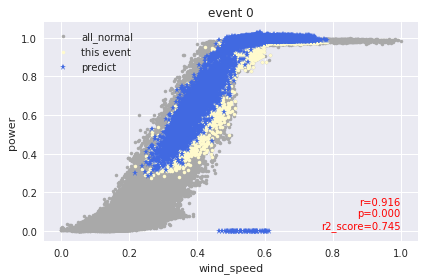

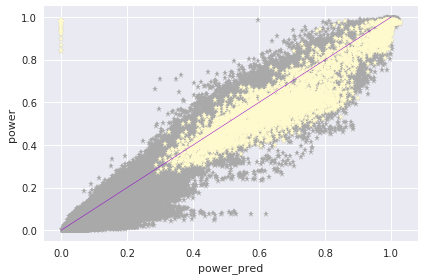

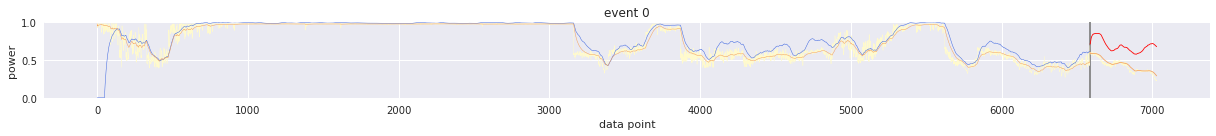

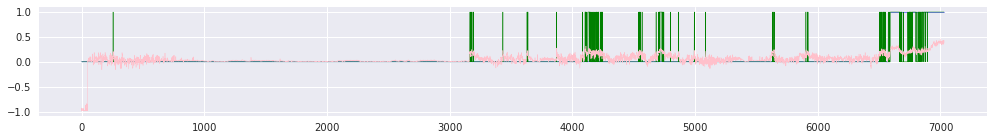

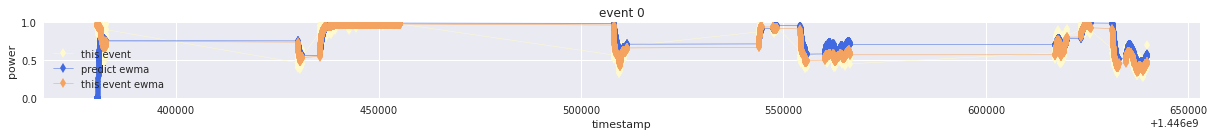

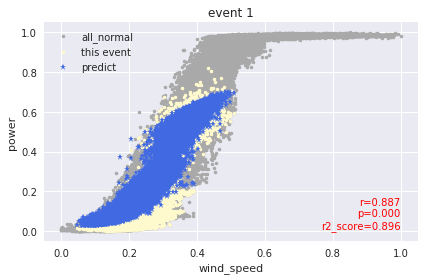

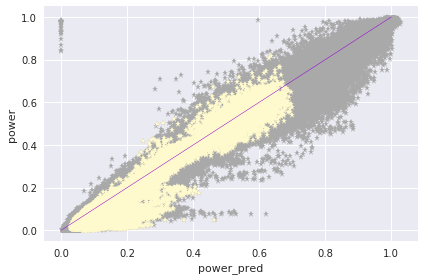

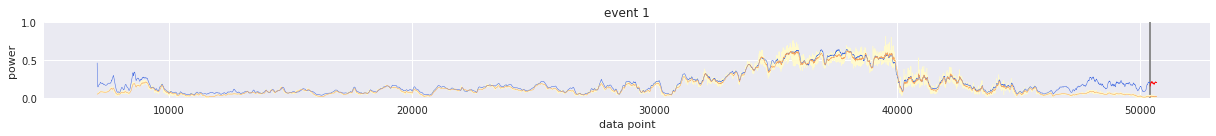

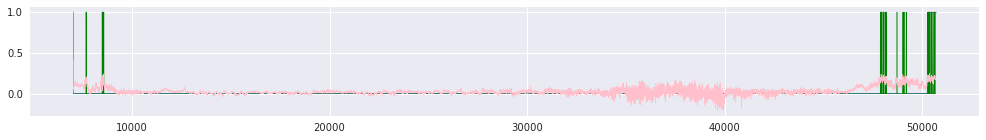

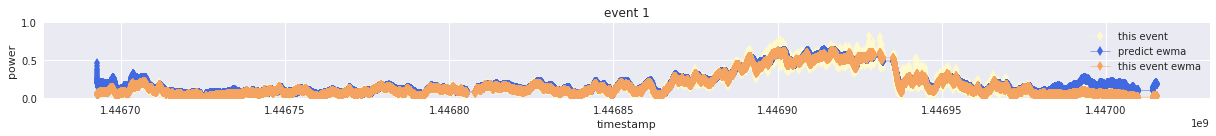

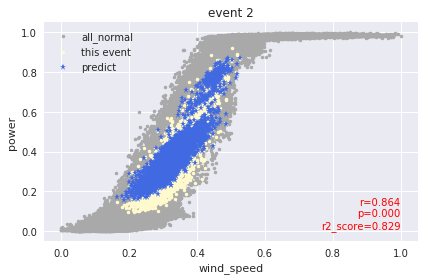

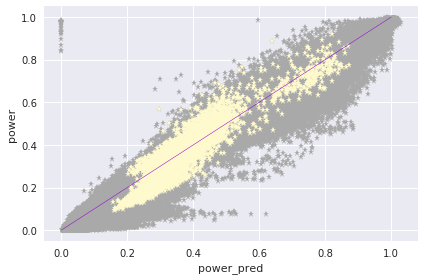

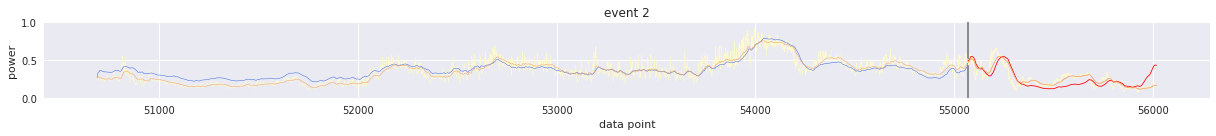

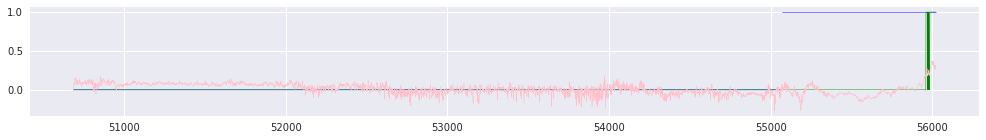

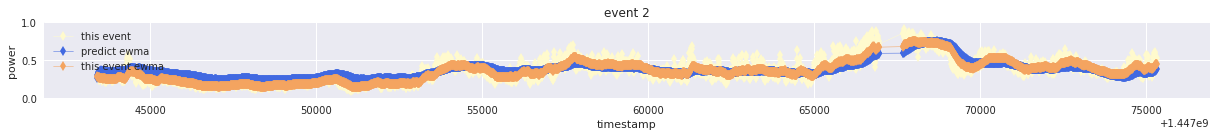

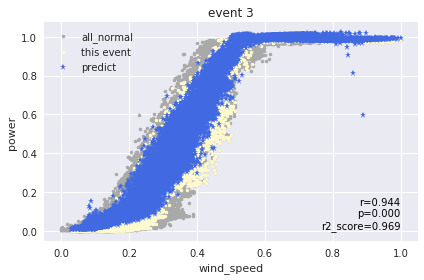

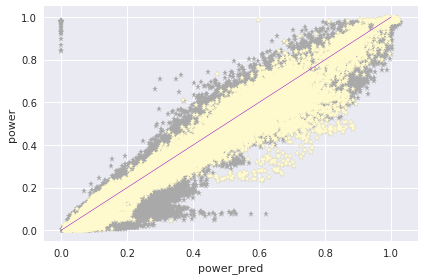

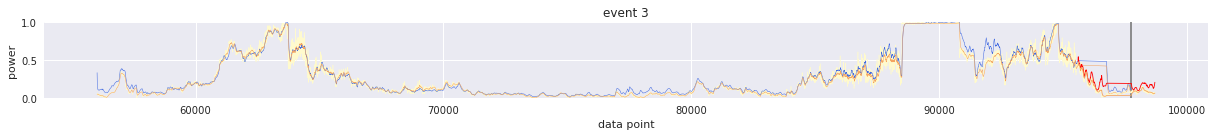

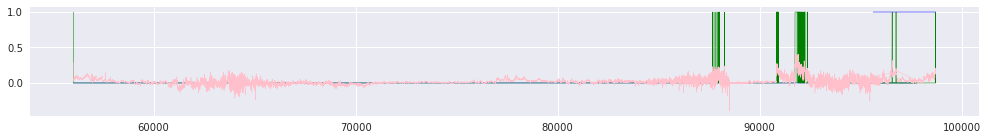

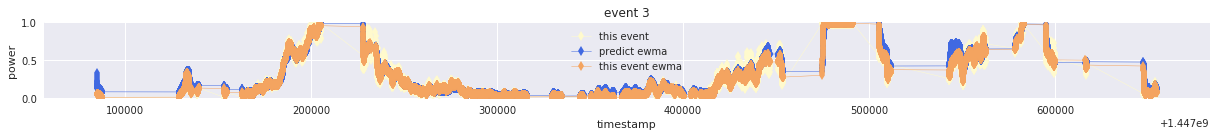

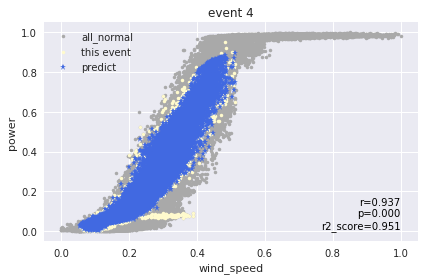

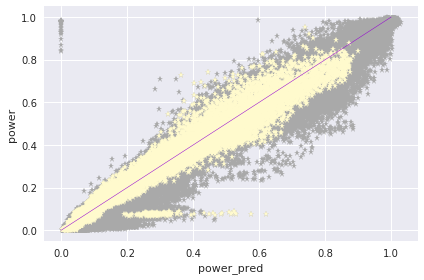

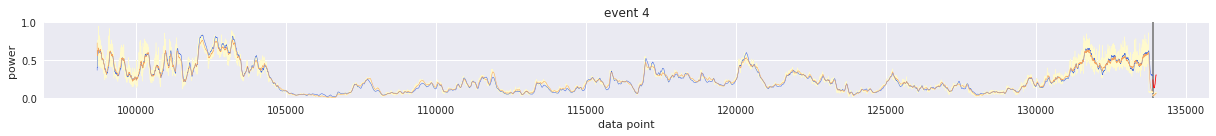

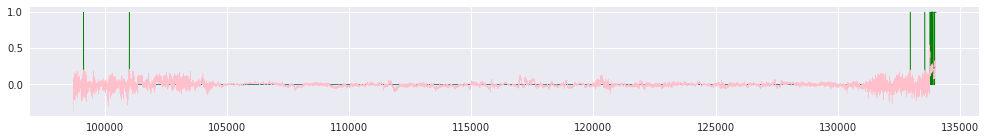

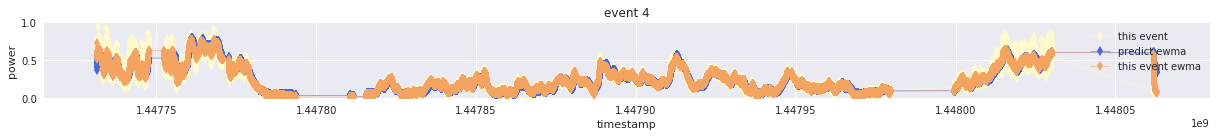

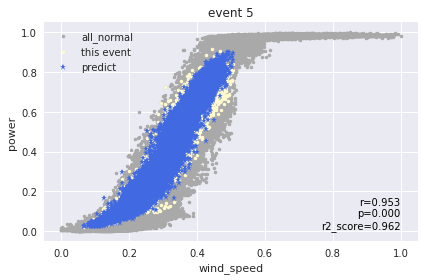

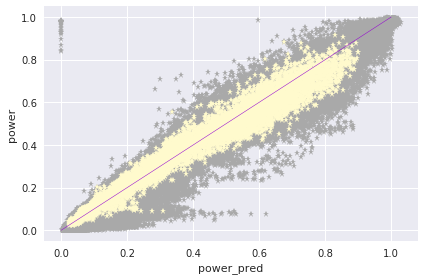

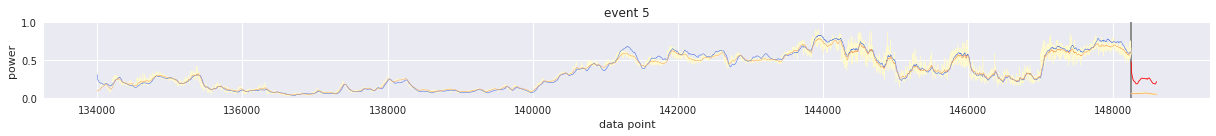

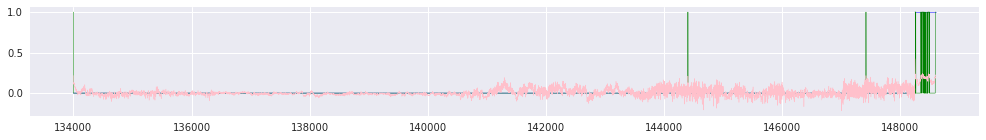

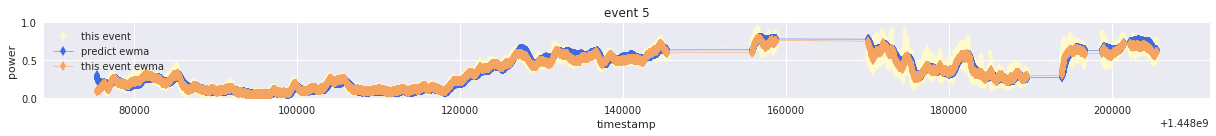

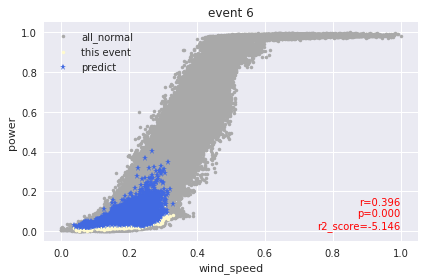

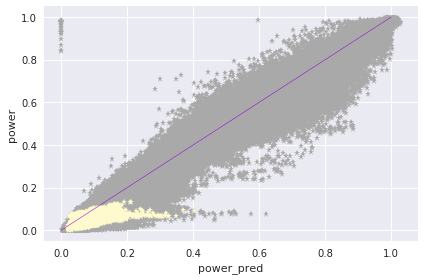

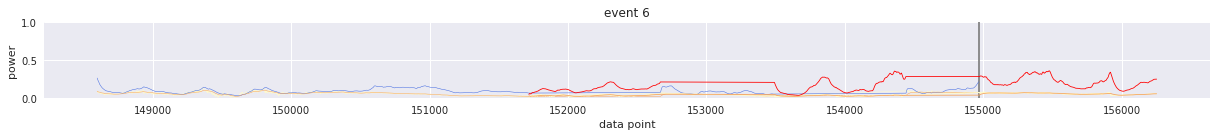

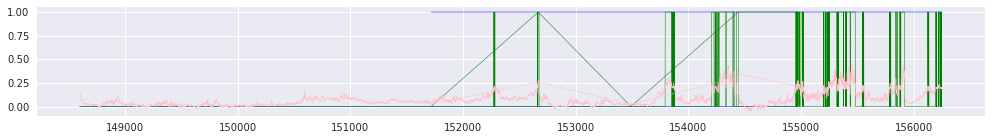

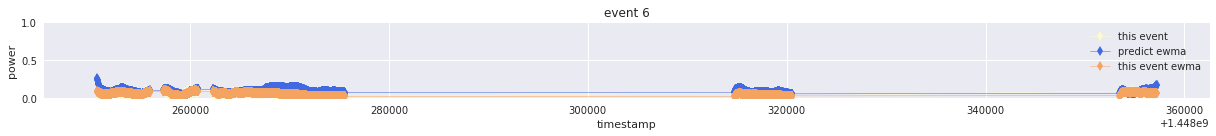

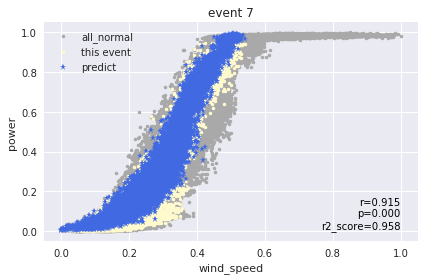

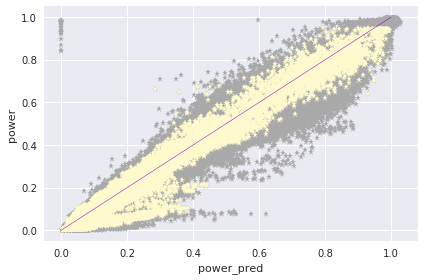

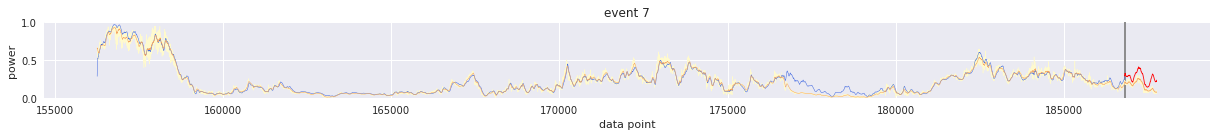

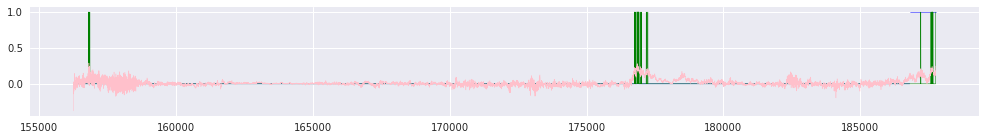

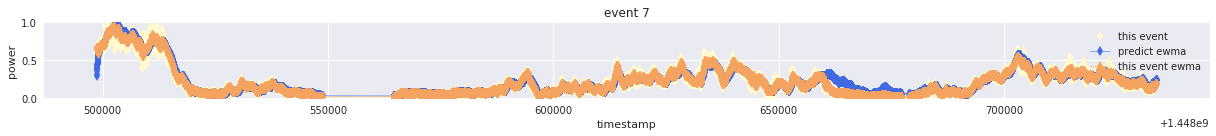

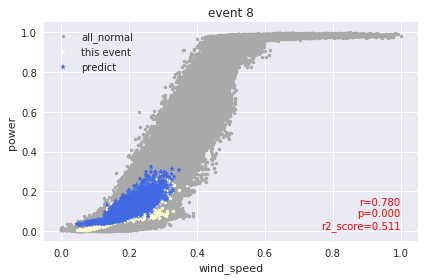

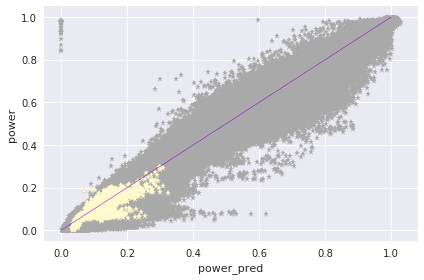

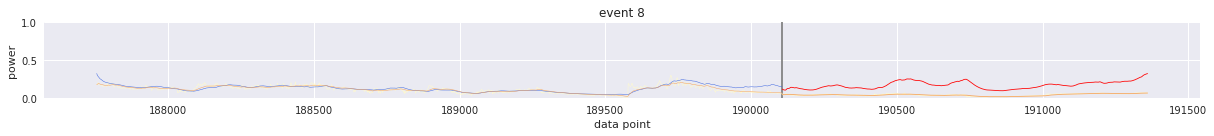

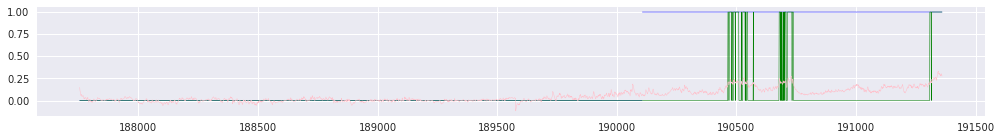

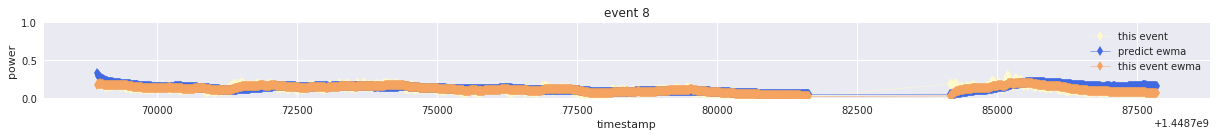

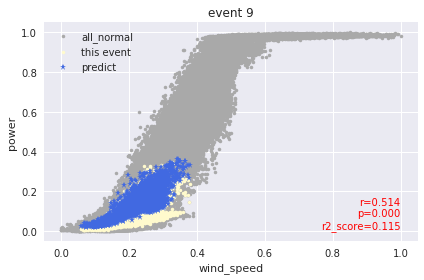

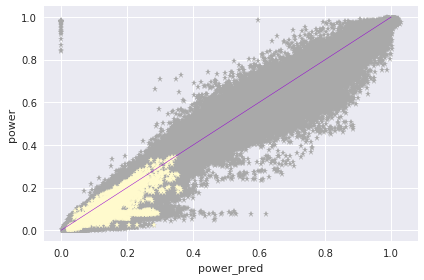

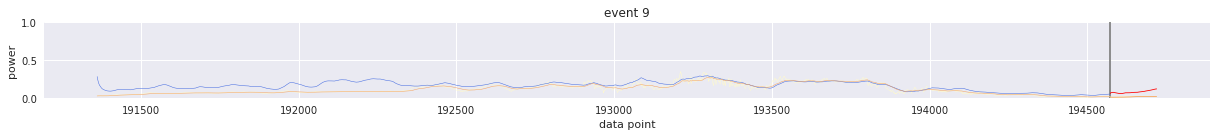

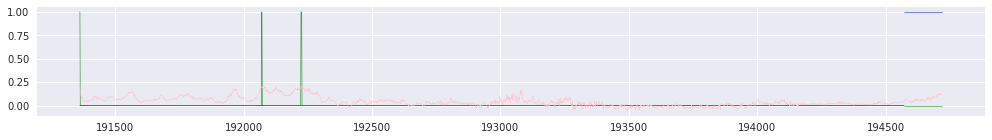

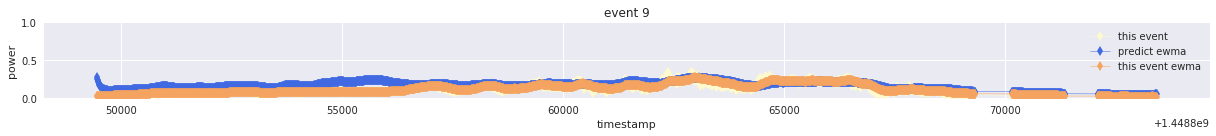

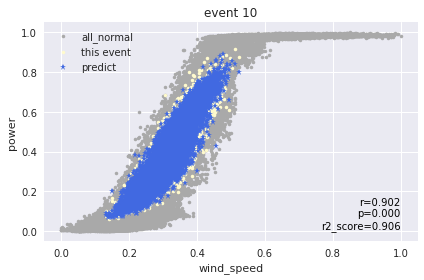

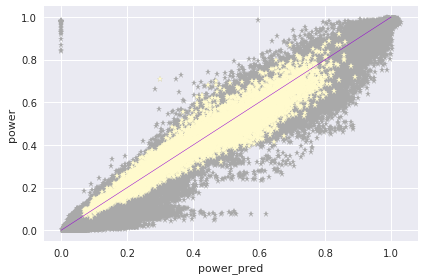

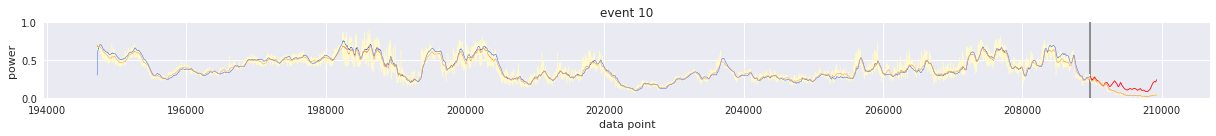

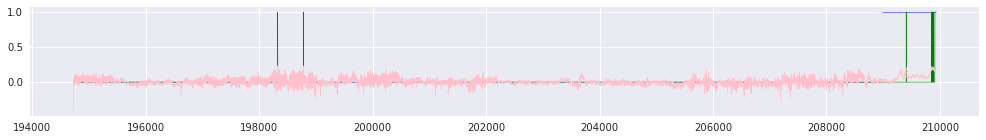

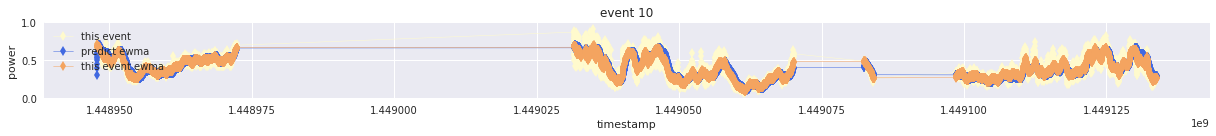

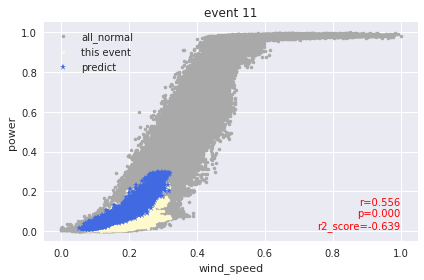

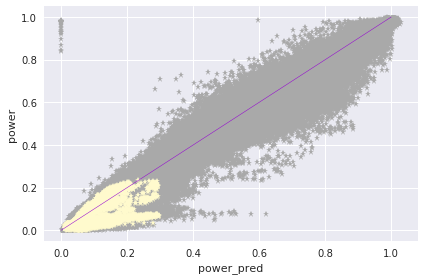

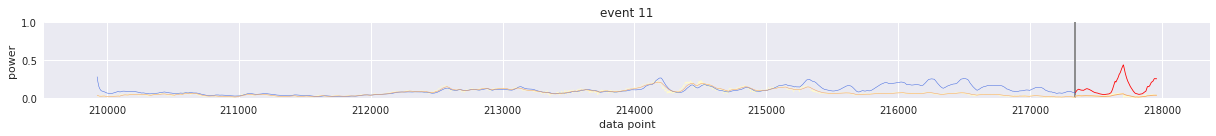

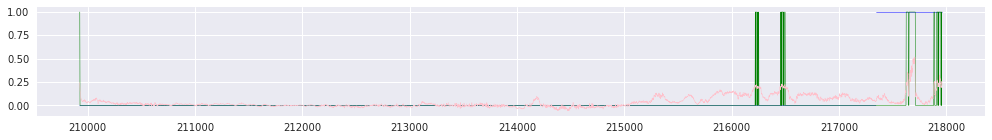

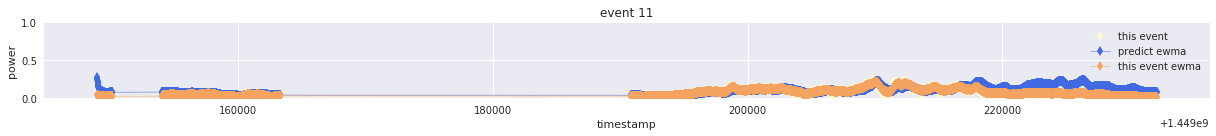

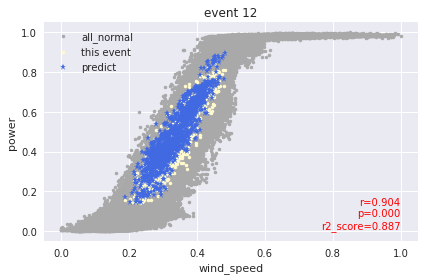

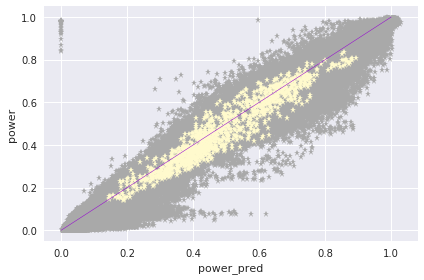

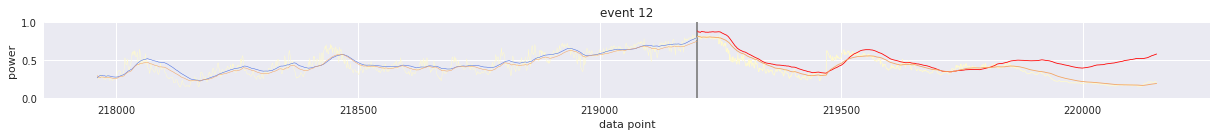

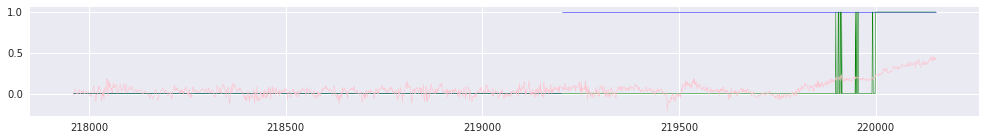

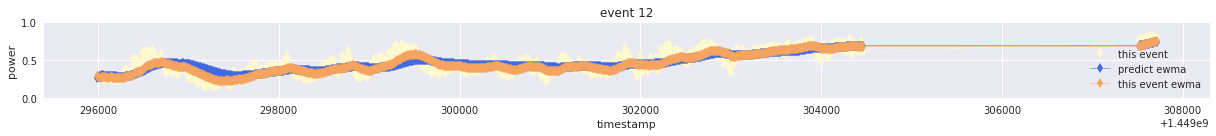

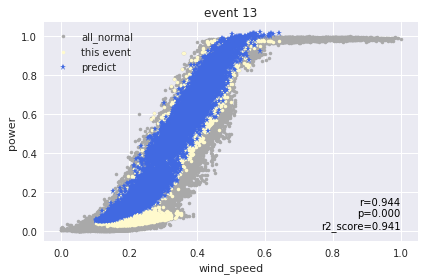

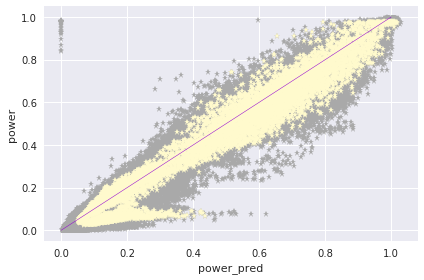

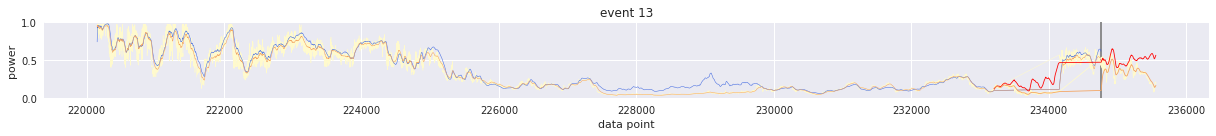

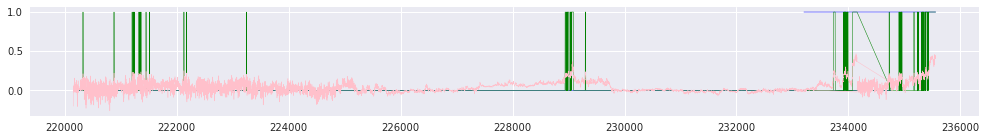

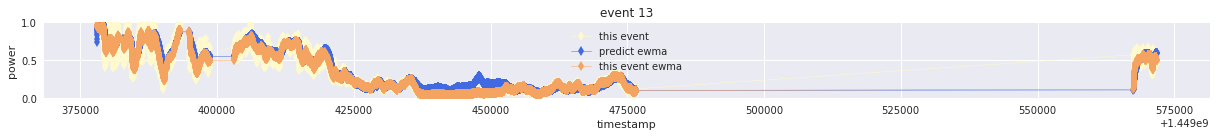

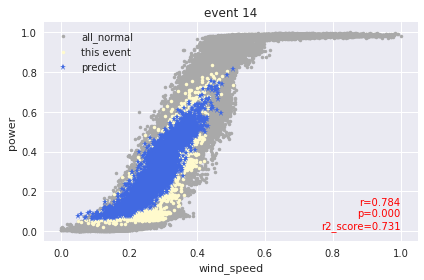

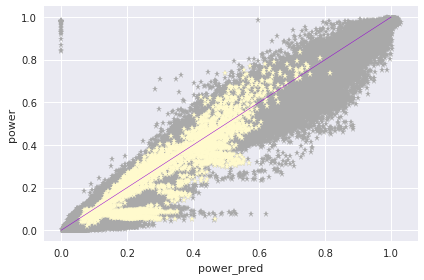

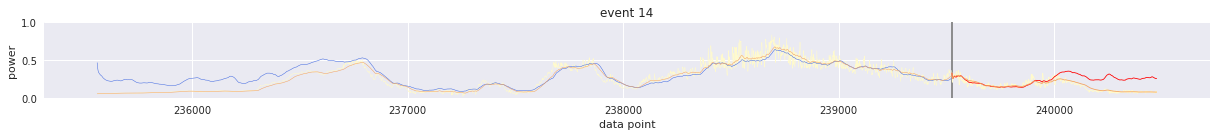

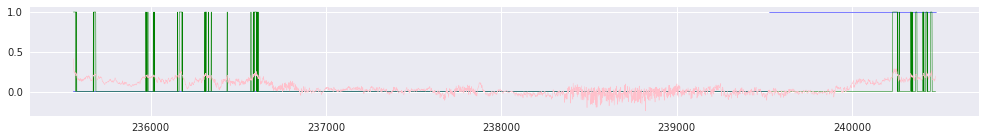

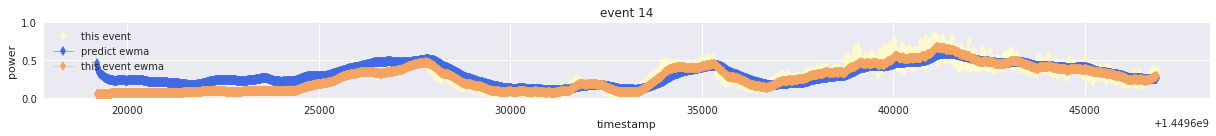

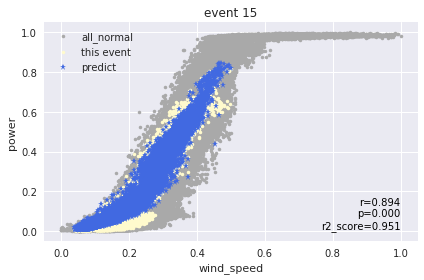

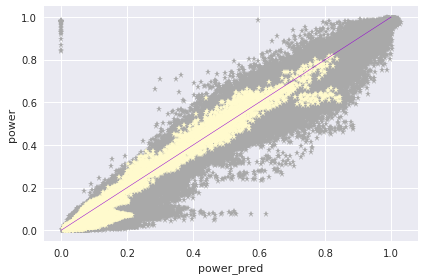

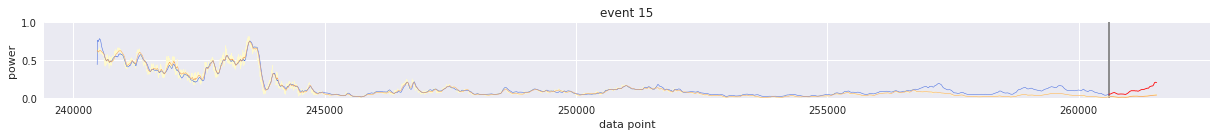

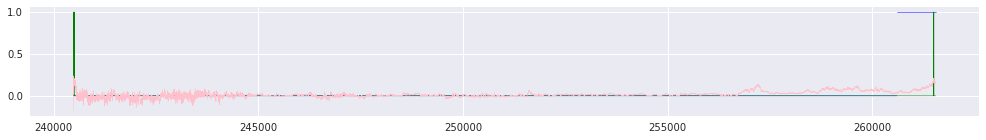

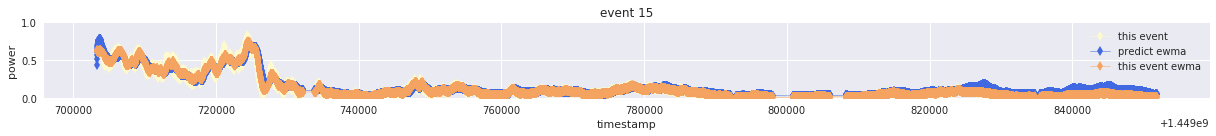

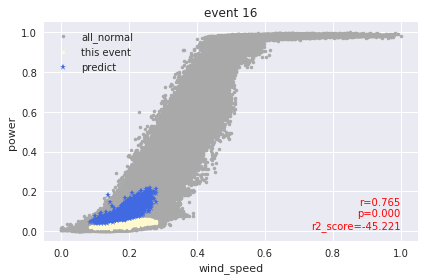

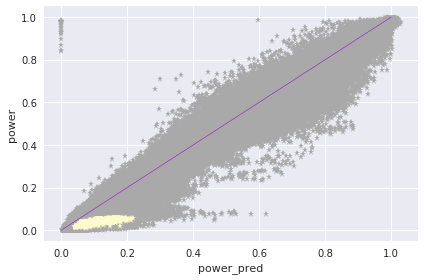

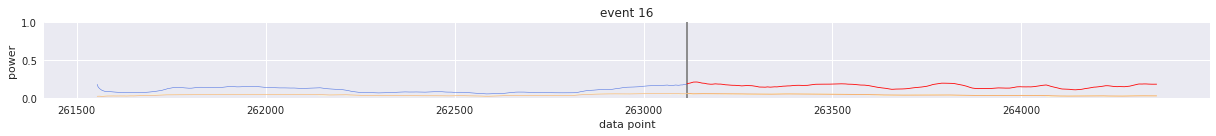

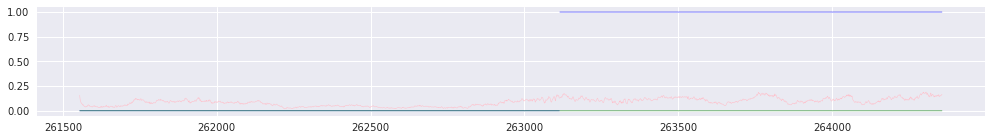

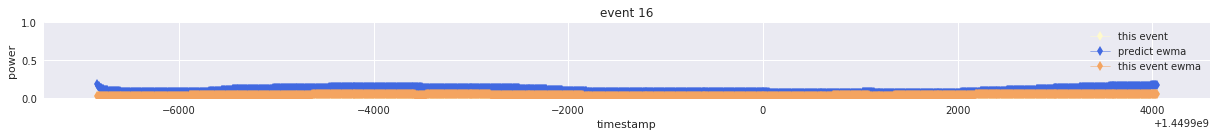

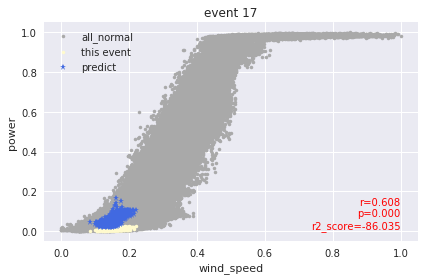

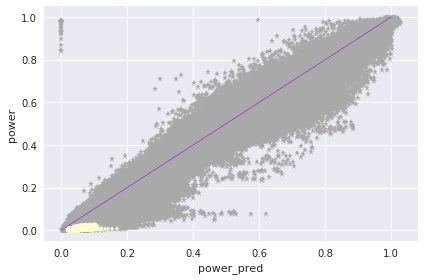

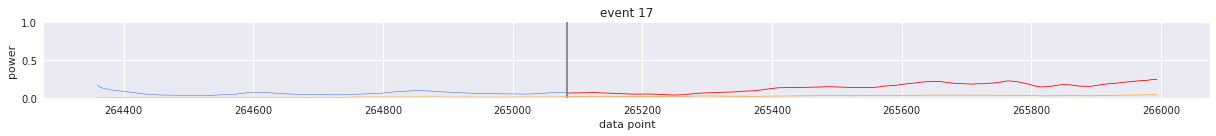

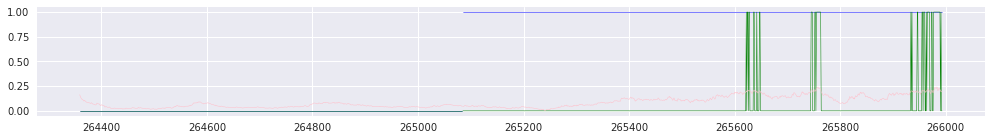

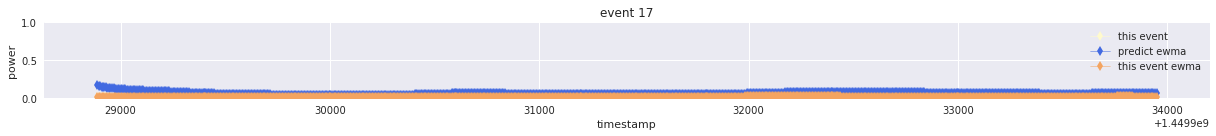

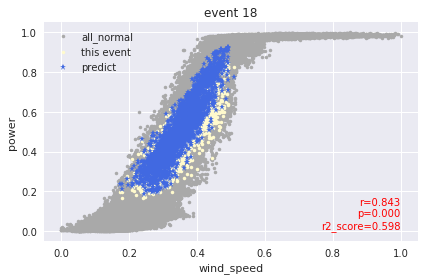

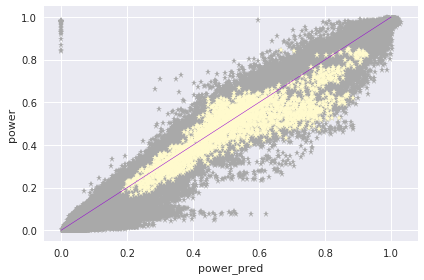

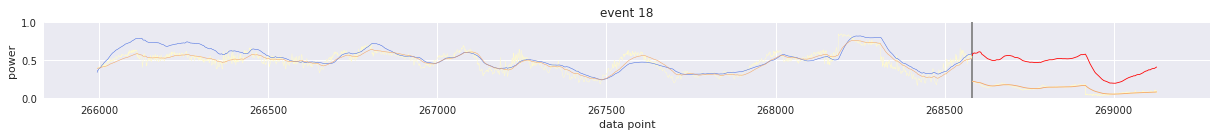

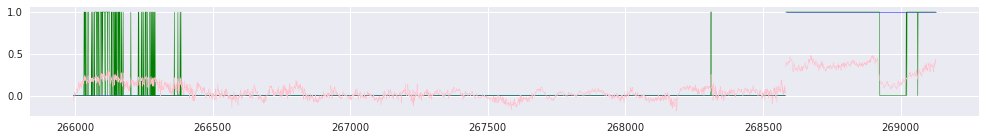

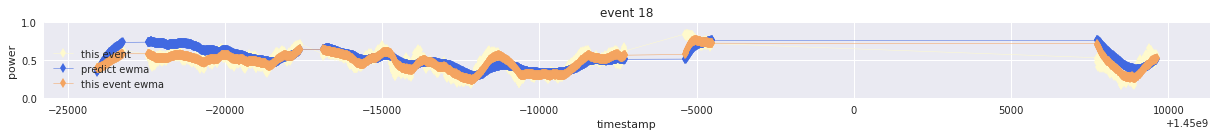

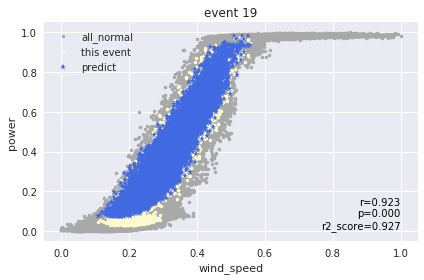

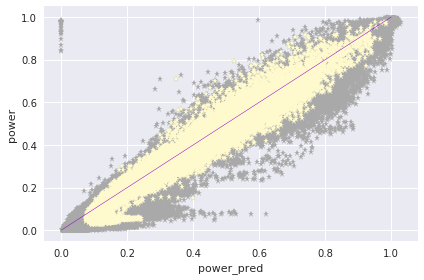

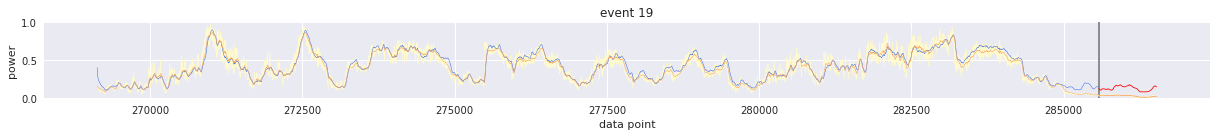

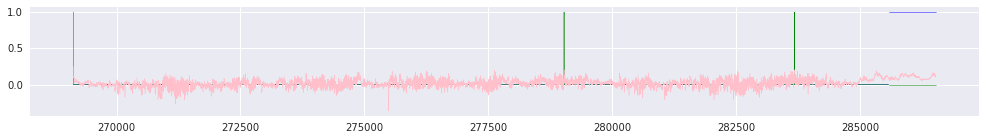

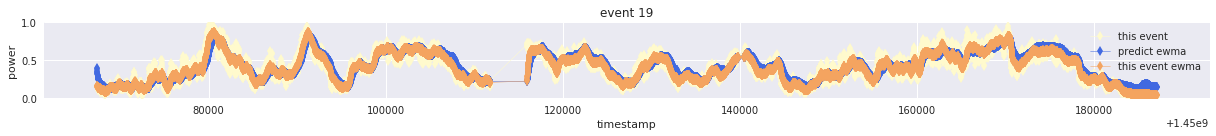

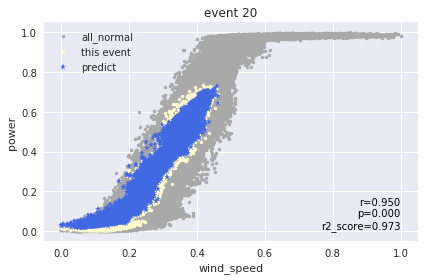

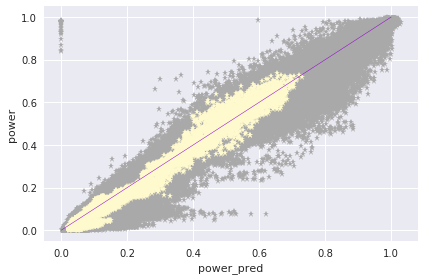

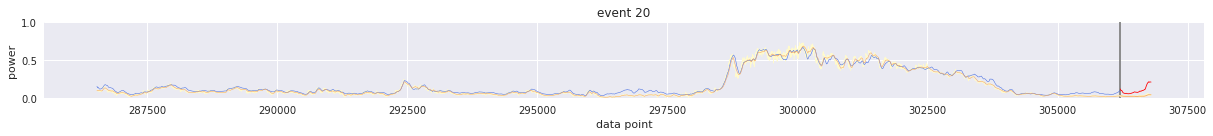

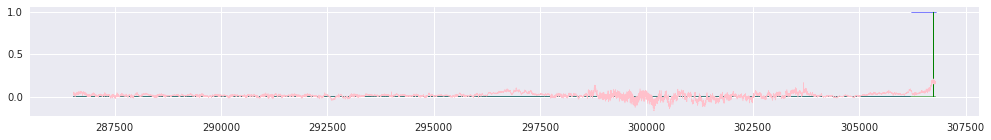

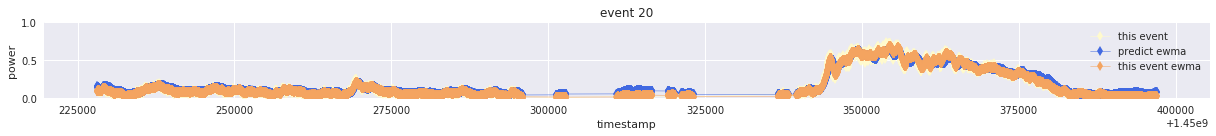

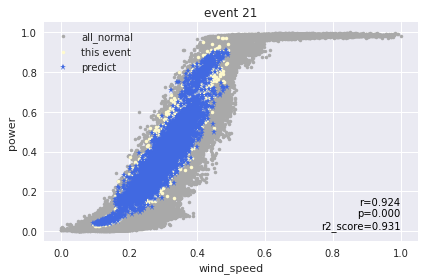

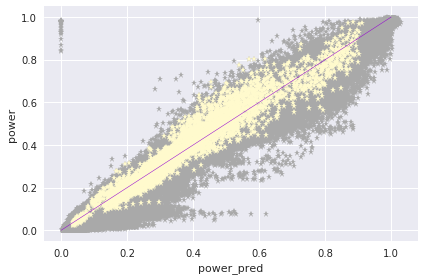

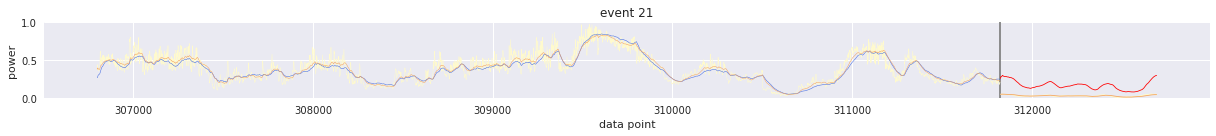

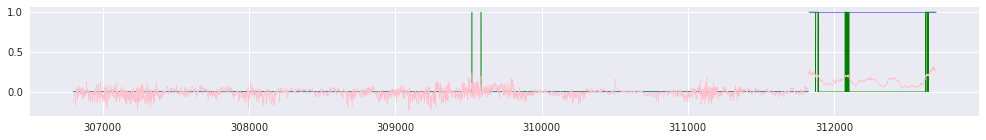

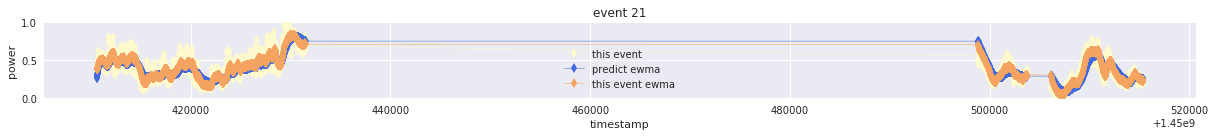

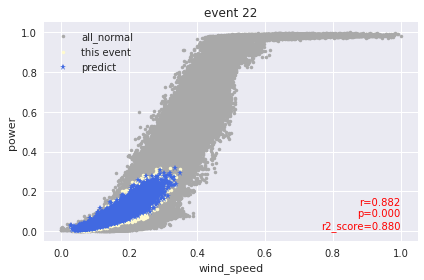

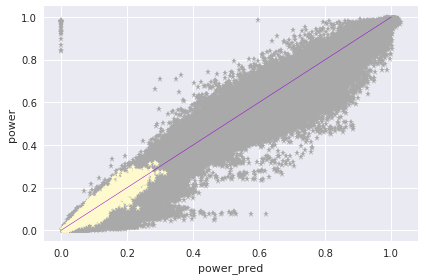

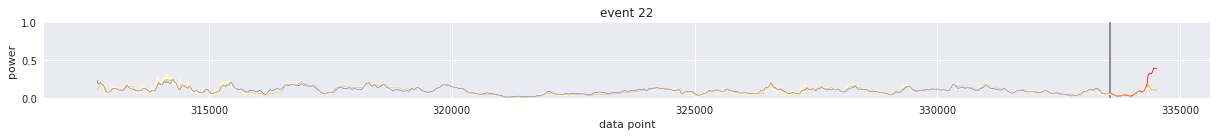

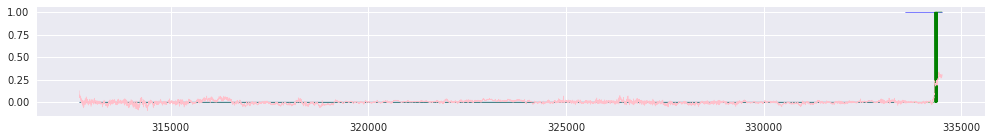

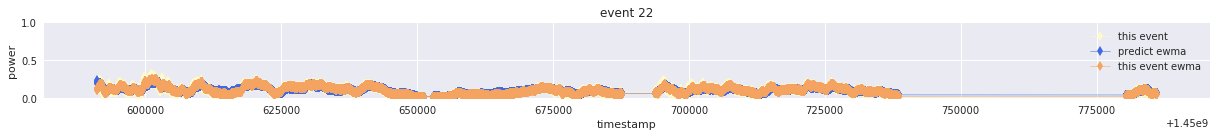

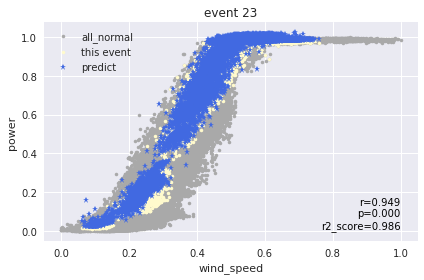

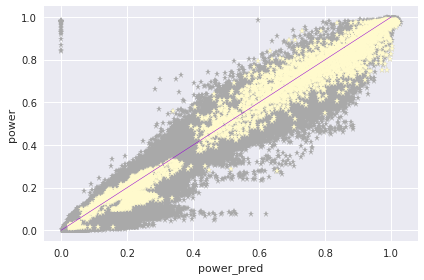

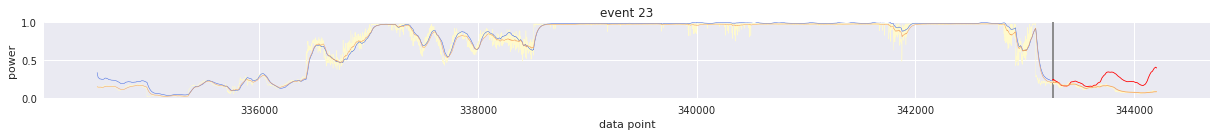

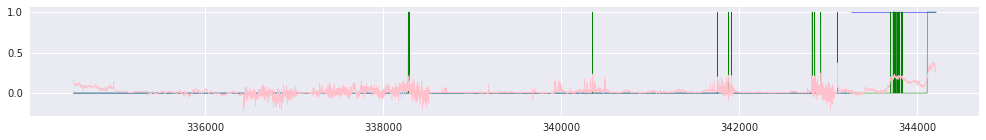

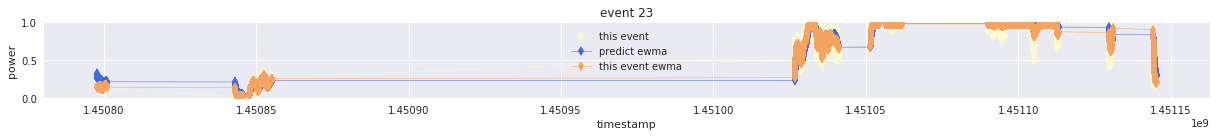

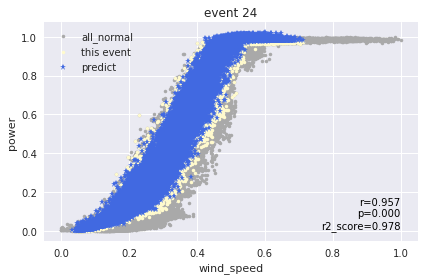

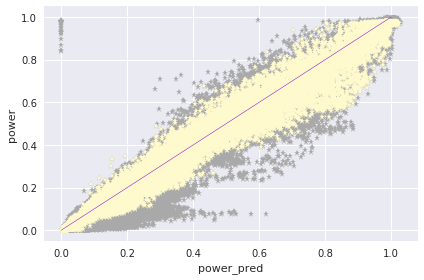

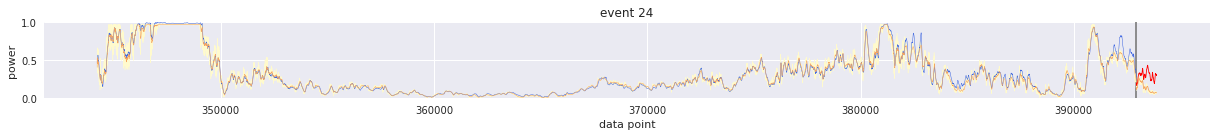

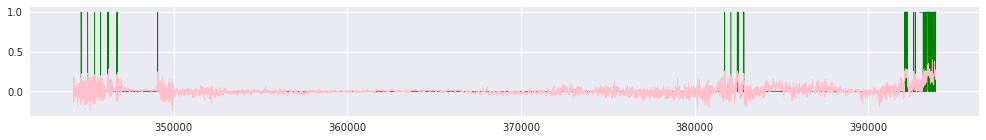

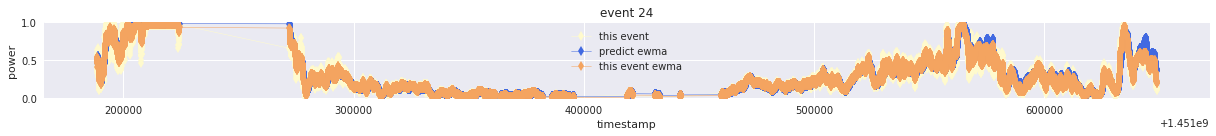

In [46]:
r2_baseline=0.9
events = data_pass['event'].unique()
x='wind_speed'
y='power'

for e in events:
    data_pass_evt= data_pass[data_pass['event']==e]
    data_fail_evt= data_fail[data_fail['event']==e]
    #data_unknown_evt = data_unknown[data_unknown['event']==e]
    r, p = pearsonr(data_pass_evt[x],data_pass_evt[y])
    raw_clr = 'lightgreen' if r>0.5 else 'darkgray'
    plt.plot(data_pass[x],data_pass[y],'.', color='darkgray', label='all_normal')
    #plt.plot(data_fail[x],data_fail[y],'.', color='lightcoral')
    #plt.plot(data_pass[x],data_pass['power_pred'],'*', color='royalblue', label='predict')
    #plt.plot(data_fail[x],y_pred_f,'*', color='firebrick')
    plt.plot(data_pass_evt[x],data_pass_evt[y],'.', color='lemonchiffon', label='this event')
    plt.plot(data_pass_evt[x],data_pass_evt['power_pred'],'*', color='royalblue', label='predict')
    r2_p = sklearn.metrics.r2_score(data_pass_evt[y],data_pass_evt['power_pred'])
    msg = 'r={corr:.3f}\np={pval:.3f}\nr2_score={r2:.3f}'.format(corr=r, pval=p,r2=r2_p)
    txt_clr = 'red' if r2_p < r2_baseline else 'black'
    plt.text(1,0,msg, color=txt_clr, horizontalalignment='right', verticalalignment='bottom')
    plt.title('event '+str(e))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.tight_layout()
    #imagename='{p}{n}.jpg'.format(p=path_scatter1,n=str(e))
    #plt.savefig(imagename,bbox_inches='tight', dpi=200)
    plt.show()
    
    plt.plot(data_pass['power_pred'], data_pass[y],'*', color='darkgray')
    plt.plot(data_pass_evt['power_pred'], data_pass_evt[y],'*', color='lemonchiffon')
    plt.plot([0,1],[0,1],color='darkviolet',lw=0.5,  label='this event ewma')
    plt.xlabel('power_pred')
    plt.ylabel('power')
    plt.tight_layout()
    #imagename='{p}{n}.jpg'.format(p=path_scatter2, n=str(e))
    #plt.savefig(imagename,bbox_inches='tight', dpi=200)
    plt.show()

    
# X: Datapoint
    # pass
    dummy = plt.figure(figsize=[17,2])
    plt.plot(data_pass_evt[y], color = 'lemonchiffon', lw=0.5, label='this event')
    plt.plot(pd.ewma(data_pass_evt['power_pred'], halflife=20), color='royalblue', lw=0.5, label='predict ewma')
    plt.plot(pd.ewma(data_pass_evt[y], halflife=20), color='sandybrown', lw=0.5, label='this event ewma')
    #plt.plot(abs(data_pass_evt['preddiff']), color='magenta', lw=0.5, label='predict diff')
    plt.vlines(data_pass_evt.index[-1],0, 1,'gray')

    
    #fail
    plt.plot(data_fail_evt[y], color = 'lemonchiffon', lw=0.8)
    plt.plot(pd.ewma(data_fail_evt['power_pred'], halflife=20), color='red', lw=0.8)
    plt.plot(pd.ewma(data_fail_evt[y], halflife=20), color='sandybrown', lw=0.8)
    #plt.plot(abs(data_fail_evt['preddiff']), color='magenta', lw=0.5, )   
    
    plt.ylim((0,1))
    plt.xlabel('data point')
    plt.ylabel(y)
    #plt.legend()
    plt.title('event '+str(e))
    plt.tight_layout()
    #imagename='{p}{n}.jpg'.format(p=path_trend1, n=str(e))
    #plt.savefig(imagename,bbox_inches='tight', dpi=200)
    plt.show()

    dummy = plt.figure(figsize=[17,2])
    plt.plot(data_pass_evt['label'],  color = 'blue', lw=0.5, label='this event')
    plt.plot(data_pass_evt['label_pred'],  color = 'green', lw=0.5, label='this event')
    plt.plot(data_fail_evt['label'],  color = 'blue', lw=0.5, label='this event')
    plt.plot(data_fail_evt['label_pred'],  color = 'green', lw=0.5, label='this event')
    plt.plot(data_pass_evt['power_diff'],  color = 'pink', lw=0.5, label='this event')
    plt.plot(data_fail_evt['power_diff'],  color = 'pink', lw=0.5, label='this event')
    
    
# X: timestamp
    dummy = plt.figure(figsize=[17,2])
    plt.plot(data_pass_evt['timestamp'], data_pass_evt[y], color = 'lemonchiffon', lw=0.5, label='this event',marker='d',)
    plt.plot(data_pass_evt['timestamp'], pd.ewma(data_pass_evt['power_pred'], halflife=50), color='royalblue', lw=0.5, label='predict ewma',marker='d',)
    plt.plot(data_pass_evt['timestamp'], pd.ewma(data_pass_evt[y], halflife=20), color='sandybrown', lw=0.5, label='this event ewma',marker='d',)
    plt.ylim((0,1))
    plt.xlabel('timestamp')
    plt.ylabel(y)
    plt.legend()
    plt.title('event '+str(e))
    plt.tight_layout()
    #imagename='{p}{n}.jpg'.format(p=path_trend2, n=str(e))
    #plt.savefig(imagename,bbox_inches='tight', dpi=200)
    plt.show()
    

** 4. 預測與準確率評估  Evaluation **

*** 